<a href="https://colab.research.google.com/github/ArjunBhaybhang/Public-Projects/blob/main/Public-Projects/NLP%20Projects/Sentiment%20Analysis%20on%20Amazon%20Reviews%20using%20n%20grams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Amazom Reviews

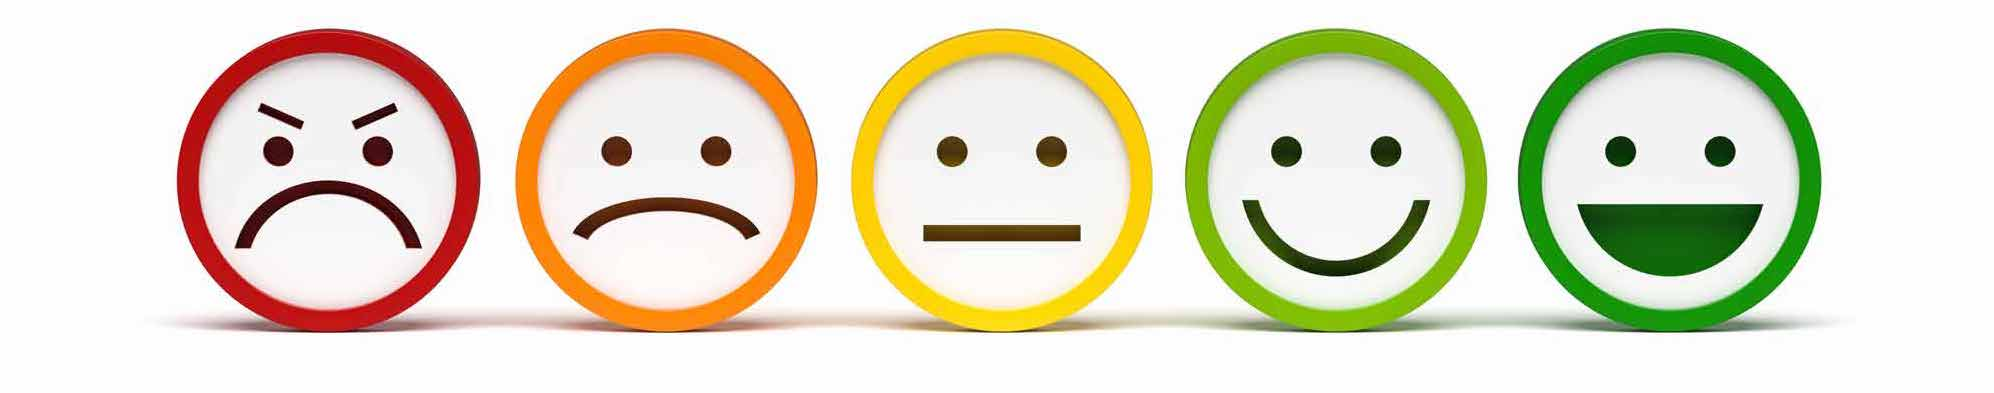

# GOAL 🎯
The purpose in this project is to classify the polarity of a given text. We will assigning polarities (Positive/Negative) to reviews for products on Amazon.com

The insights gained through sentiment analysis provide an efficient way to monitor and improve the online reputation. Access to sentiment information at scale means we can better maintain the pulse of online community. This enables us to strategize more effectively and deal with problems before they escalate.



# About Data 🗄
The data used here was acquired in December, 2016 by the crawlers build to deliver data extraction services. PromptCloud extracted 400 thousand reviews of unlocked mobile phones sold on Amazon.com to find out insights with respect to reviews, ratings, price and their relationships.

## Imports

In [1]:
%load_ext google.colab.data_table
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Load Data
Lets load the data and take a have a quick look.

In [2]:
reviews = pd.read_csv('/content/drive/MyDrive/Datasets/Amazon Reviews Sentiment Analysis Text Mining Week 3/Amazon_Unlocked_Mobile.csv')
reviews.head(3)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0


In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


Dataset contains 6 columns. The reviews column is the one we are most interested in. We will be deducting our sentiment from the text in this column.

## Cleaning Data

In [4]:
# Dropping na values
reviews.dropna(inplace=True)

# Drop nutral reviews where rating = 3
reviews = reviews[reviews['Rating'] != 3]

So far, we do not have any target label, which is needed for any supervised learning. We can derive the target from the Rating column. We will consider reviews with a 'Rating' greater than three as positive(1) and reviews with a rating less than three as non-positive(0). We can use more steps for finer segregation but this will do for now.

In [ ]:
reviews['Positive'] = np.where(reviews['Rating'] > 3,1,0);

Lets see how our ratings are distributed

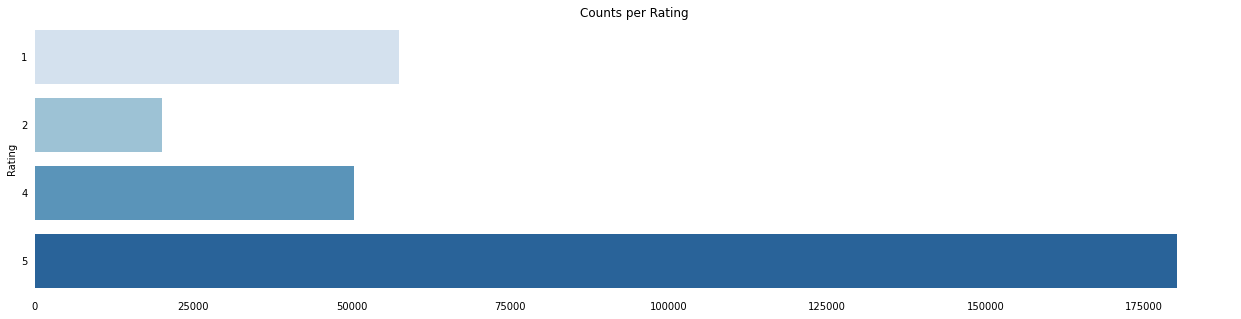

In [6]:
plt.figure(figsize=(21.5,5))
sns.countplot(y=reviews['Rating'], alpha=1, palette='Blues');
sns.despine(top=True, bottom=True, left=True)
plt.tick_params(left=False, bottom=False)
plt.xlabel('');
plt.title('Counts per Rating');

Looks like we have more instances where the rating was more than three. This might create imbalanced class distribution. Lets take a look at what percaentage of reviews are positive.

In [7]:
# check for class imbalance
print('Percentage of positive class : ', reviews['Positive'].mean() * 100)

Percentage of positive class :  74.82686025879323


## Preprocessing Data

In [8]:
# Spliting data into train-test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews['Reviews'], reviews['Positive'], random_state=0)

In [9]:
# CountVectorizer lets us use the bags of words approach, it tokanizes(finding atleaast 2 letters or numbers seperated by boundries)
# & lowercases them to create features 
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)

In [10]:
# Lets take a look at every 5000th feature
vect.get_feature_names()[::5000]

['00',
 'andentering',
 'cassettes',
 'deғιnιтely',
 'flashy',
 'inefficiencies',
 'microsaudered',
 'phalet',
 'responseive',
 'storecons',
 'utiles']

## Lets calculate the number of features before we start training our model

In [11]:
# Number of features
print('Number of features : ', len(vect.get_feature_names()))

Number of features :  53216


We will reansform the training set into a sparce matrix which will be used to fit our model.

In [12]:
X_train_vectorised = vect.transform(X_train)
X_train_vectorised

<231207x53216 sparse matrix of type '<class 'numpy.int64'>'
	with 6117776 stored elements in Compressed Sparse Row format>

#The Model 

We can use Logestic Regression model to solve this problem, we can use it with default parameters with number of iterations set to 1000,  to make sure our model converges.

In [13]:
# Train Logestic Regression Model
from sklearn.linear_model import LogisticRegression

log_model =  LogisticRegression(max_iter=1000)
log_model.fit(X_train_vectorised, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluation

# Lets first calculate AUC and ROC score of our model :

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

predictions = log_model.predict(vect.transform(X_test))
pred_proba = log_model.predict_proba(vect.transform(X_test))[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)

print('AUC : ', roc_auc_score(y_test, pred_proba))

AUC :  0.979519907982701


Lets plot ROC and Precision Recall Curve

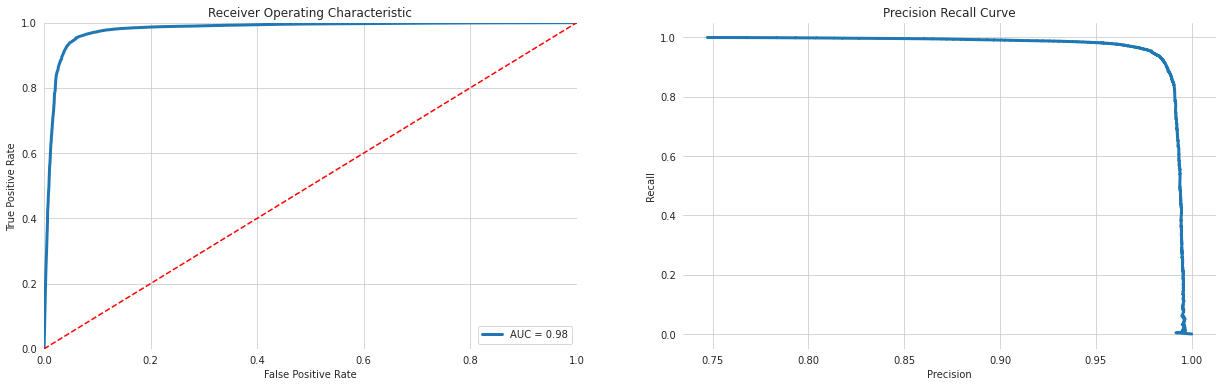

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=(21,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic')
sns.lineplot(x=fpr, y=tpr, label = 'AUC = %0.2f' % roc_auc, palette='Blues', linewidth=3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tick_params(left=False, bottom=False)
sns.despine(top=True, bottom=True, left=True)

# calculate precision-recall curve
from sklearn.metrics import precision_recall_curve, f1_score
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)

plt.subplot(1,2,2)
plt.plot(precision, recall, linewidth=3)
sns.despine(top=True, bottom=True, left=True)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve');

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     19500
           1       0.96      0.98      0.97     57570

    accuracy                           0.95     77070
   macro avg       0.95      0.93      0.94     77070
weighted avg       0.95      0.95      0.95     77070



Great, looks like our model is performs satisfactory. 

# Lets take a look at some Prediction Insights.
1). What features(words) that contribute strongly towards predicting a Positive class.


In [17]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = log_model.coef_[0].argsort()

print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Largest Coefs: 
['excelent' 'excelente' '4eeeks' 'exelente' 'efficient' 'excellent'
 'loving' 'pleasantly' 'loves' 'mn8k2ll']


2). What features(words) strongly predict a negative class.

In [18]:
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))

Smallest Coefs:
['mony' 'worst' 'false' 'worthless' 'horribly' 'messing' 'unsatisfied'
 'blacklist' 'junk' 'garbage']



## That seems accurate. 🏅
But we are not done yet, we can further improve the model performance by using some advance techniques.

## Reducing Features with Tfidf
### So far we have been using about **53216** features. But are all of these features important? What if we train our model with fewer features by eleminating unnecessary features? Would it affect our model performance?

### Lets try out ⚖

Lets use features(words) which appear atleast 5 times throught the entire data of reviews. This will get rid of features that are used only few times.

In [19]:
# Use Tfidf to reduce number of features
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(X_train)
print('Number of features after reduction with Tfidf : ', len(vect.get_feature_names()))

Number of features after reduction with Tfidf :  17951


## Awesome! we were able to reduce the number of features by almost three folds. 🎉
But how does our model perform with this reduced features? Lets find out.

In [21]:
X_train_vectorized = vect.transform(X_train)

model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_vectorized, y_train)

pred_proba_tfidf = model_tfidf.predict_proba(vect.transform(X_test))[:,1]

In [22]:
predictions_tfidf = model_tfidf.predict(vect.transform(X_test))

fpr_tfidf, tpr_tfidf, threshold_tfidf = roc_curve(y_test, pred_proba_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

print('AUC : ', roc_auc_score(y_test, pred_proba_tfidf))

AUC :  0.982169958534315


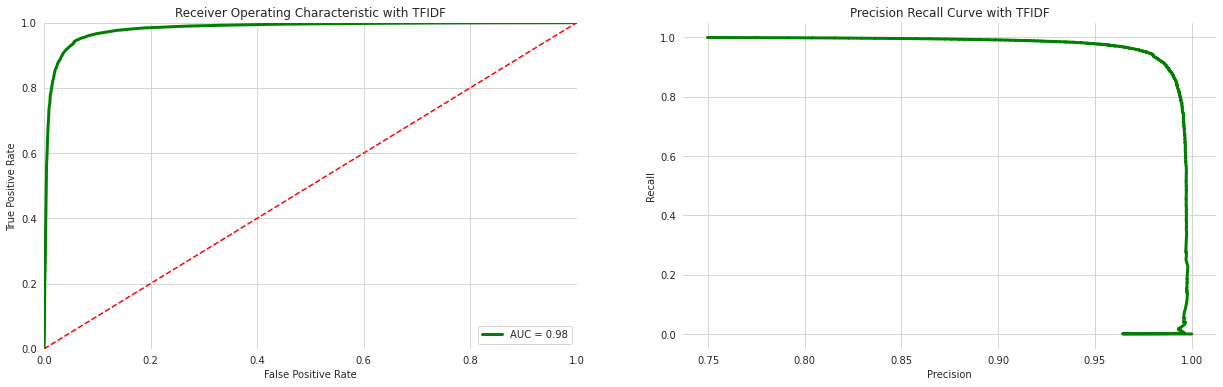

In [23]:
plt.figure(figsize=(21,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic with TFIDF')
sns.lineplot(x=fpr_tfidf, y=tpr_tfidf, label = 'AUC = %0.2f' % roc_auc_tfidf, color='green', linewidth = 3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tick_params(left=False, bottom=False)
sns.despine(top=True, bottom=True, left=True)

# calculate precision-recall curve
from sklearn.metrics import precision_recall_curve, f1_score
precision_tfidf, recall_tfidf, thresholds_tfidf = precision_recall_curve(y_test, pred_proba_tfidf)

plt.subplot(1,2,2)
plt.plot(precision_tfidf, recall_tfidf, color='green', linewidth = 3)
sns.despine(top=True, bottom=True, left=True)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve with TFIDF');

## Well the performance of the model is slightly better to that without feature reduction, but is it really worth it?
It certainly is, now out model trains on three folds less data reducing the runtime and also saving on precious resources. So we have a faster model with slightly better accuracy than previous approach. 😎

### Lets take a look at features with smallest Tfidf and Largest Tfidf

In [25]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['commenter' 'pthalo' 'warmness' 'storageso' 'aggregration' '1300'
 '625nits' 'a10' 'submarket' 'brawns']

Largest tfidf: 
['defective' 'batteries' 'gooood' 'epic' 'luis' 'goood' 'basico'
 'aceptable' 'problems' 'excellant']


##Also lets look at the features(words) that contribute strongly towards predicting a Positive class.

In [27]:
sorted_coef_index = model_tfidf.coef_[0].argsort()
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Largest Coefs: 
['love' 'great' 'excellent' 'perfect' 'amazing' 'awesome' 'perfectly'
 'easy' 'best' 'loves']


## And looking at the features(words) that contribute strongly towards predicting a Negative class.

In [28]:
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))

Smallest Coefs:
['not' 'worst' 'useless' 'disappointed' 'terrible' 'return' 'waste' 'poor'
 'horrible' 'doesn']



The list has certainly changed after Tfidf, getting rid of unnecessary features has indeed brought clearity to our model. 

## Looks like we are done, but just one last step I promise ✋
Although our model performs great already there is one small concern we need to take in account.
So far in the bag of words approach our model predicted a positive class if the review included some specific words like ('love' 'great' 'excellent' 'perfect'.. etc). 
but we also need to take in account the context these words are used in. Let me show you an example :

In [35]:
print('Review 1: "not an issue, phone is working" class : ' , model_tfidf.predict(vect.transform(['not an issue, phone is working'])))
print('Review 2: "an issue, phone is not working" class : ' , model_tfidf.predict(vect.transform(['an issue, phone is not working'])))

Review 1: "not an issue, phone is working" class :  [0]
Review 2: "an issue, phone is not working" class :  [0]


In both the cases above the model predicts class 0 (Negative) becasue both reviews contain 'issue'. However we can clearly see the first review is Positive Sentiment. How do we correct this? I have a quick fix for this. 

So far in the bag of words we were completly ignoring the context the words are used in. For example "not and issue" & "an issue" both are branched under same sentiment.

With n-grams technique we can make our model observe the context we use the features in. By setting n-gram(1,2) we make our model look for words around the features and observe the context in which the current feature is being used.

## Using n-gram

In [40]:
# Fit the CountVectorizer to the training data specifiying a minimum document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

print('Number of features after n-gram : ', len(vect.get_feature_names()))

Number of features after n-grams :  198917


Watchout, the number of features exploded after using n grams. We were careful to apply n-gram after Tfidf reduction or else the feature count would have be even higher.

## Lets see how our model performs after n-gram 

In [44]:
model_ngram = LogisticRegression(max_iter=1000)
model_ngram.fit(X_train_vectorized, y_train)

predictions_ngram = model_ngram.predict(vect.transform(X_test))

In [43]:
pred_proba_ngram = model_ngram.predict_proba(vect.transform(X_test))[:,1]
fpr_ngram, tpr_ngram, threshold_ngram = roc_curve(y_test, pred_proba_ngram)
roc_auc_ngram = auc(fpr_ngram, tpr_ngram)

print('AUC : ', roc_auc_score(y_test, pred_proba_ngram))

AUC :  0.9900381755989366


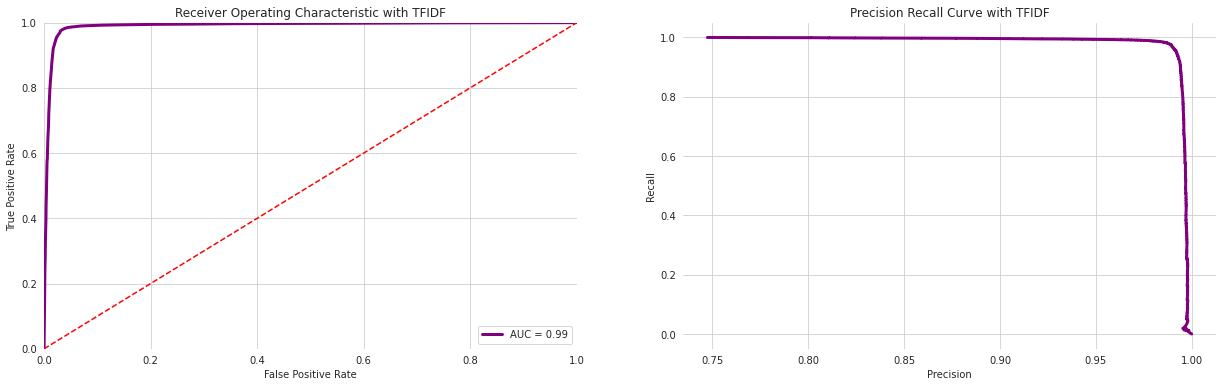

In [48]:
plt.figure(figsize=(21,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic with TFIDF')
sns.lineplot(x=fpr_ngram, y=tpr_ngram, label = 'AUC = %0.2f' % roc_auc_ngram, color='purple', linewidth = 3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tick_params(left=False, bottom=False)
sns.despine(top=True, bottom=True, left=True)

# calculate precision-recall curve
precision_ngram, recall_ngram, thresholds_ngram = precision_recall_curve(y_test, pred_proba_ngram)

plt.subplot(1,2,2)
plt.plot(precision_ngram, recall_ngram, color='purple', linewidth = 3)
sns.despine(top=True, bottom=True, left=True)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve with TFIDF');

Wow, we were further able to improve a already great model. Lets look at what features contribute to Positive and negatibve class after n-gram. We might see 2-3 words grouped together in the list. 😮

## Looking at Features contributing strongly towards predicting a Positive class after n-gram.

In [52]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Largest Coefs: 
['not bad' 'excelent' 'excelente' 'excellent' 'perfect' 'no problems'
 'exelente' 'awesome' 'no issues' 'great']


## Features contributing strongly towards predicting a Negative class after n-gram.

In [51]:
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))

Smallest Coefs:
['no good' 'worst' 'junk' 'not good' 'not happy' 'horrible' 'garbage'
 'terrible' 'looks ok' 'nope']



## Even better our model now consides the context the features are used in.🍻
Lets test it on our example if the model can now differentiate between the positive and negative class.

In [57]:
# These reviews are now correctly identified
print('Review 1: "not an issue, phone is working" class : ' , model_ngram.predict(vect.transform(['not an issue, phone is working'])))
print('Review 2: "an issue, phone is not working" class : ' , model_ngram.predict(vect.transform(['an issue, phone is not working'])))

Review 1: "not an issue, phone is working" class :  [1]
Review 2: "an issue, phone is not working" class :  [0]


## Looks like we have solved our issue! The model can now identify sentiment of reviews correctly while considering the context of the words they are used in. This model is now ready to be used in commercial environment!

In [58]:
print(classification_report(y_test, predictions_ngram))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     19500
           1       0.98      0.99      0.98     57570

    accuracy                           0.98     77070
   macro avg       0.97      0.97      0.97     77070
weighted avg       0.98      0.98      0.98     77070

